In [19]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.few_shot.datasets.omniglot import OmniglotSet
from torchlake.few_shot.models import SiameseNetwork
from torchvision import transforms
from tqdm import tqdm

# Setting

In [3]:
BATCH_SIZE = 128
SET_SIZE = 1000

In [4]:
artifact_path = Path('../../artifacts/siamese')
data_path = Path('../../data')

In [5]:
device = torch.device("cuda:0")

# Data

In [6]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
dataset = OmniglotSet(
    data_path.as_posix(),
    SET_SIZE,
    transform=preprocess,
    language="Armenian",
)

In [8]:
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

  0%|          | 0/7 [00:00<?, ?it/s]

tensor([0.])


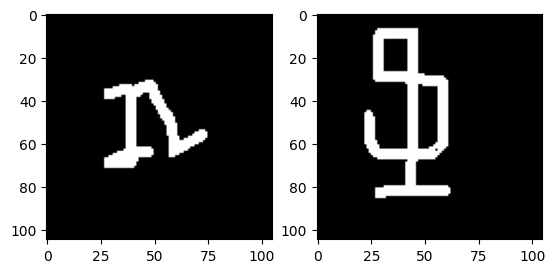

In [9]:
# 繪圖
for img1, img2, label in tqdm(loader):
    img1, img2 = img1.numpy(), img2.numpy()
    img1, img2 = np.rollaxis(img1, 1, 4), np.rollaxis(img2, 1, 4)
    img1, img2 = np.squeeze(img1, 3), np.squeeze(img2, 3)

    plt.subplot(1, 2, 1)
    plt.imshow(img1[0], cmap="gray_r")
    plt.subplot(1, 2, 2)
    plt.imshow(img2[0], cmap="gray_r")
    print(label[0])
    break

In [10]:
few_shot_dataset = OmniglotSet(
    data_path.as_posix(),
    SET_SIZE,
    transform=preprocess,
    language="Armenian",
    enable_kshot=True,
    shot_size=1,
)

In [11]:
few_shot_loader = DataLoader(
    few_shot_dataset,
    batch_size=BATCH_SIZE // 4,
    shuffle=True,
    drop_last=True,
)

# model

In [20]:
label_size = len(dataset.char_paths)

In [12]:
model = SiameseNetwork(1).to(device)

In [13]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
SiameseNetwork                           --
├─Sequential: 1-1                        --
│    └─ConvBnRelu: 2-1                   --
│    │    └─Conv2d: 3-1                  3,200
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─ConvBnRelu: 2-3                   --
│    │    └─Conv2d: 3-4                  100,352
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─MaxPool2d: 2-4                    --
├─Sequential: 1-3                        --
│    └─ConvBnRelu: 2-5                   --
│    │    └─Conv2d: 3-7                  73,728
│    │    └─BatchNorm2d: 3-8             256
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       2,654,464
│    └

# training

In [13]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=0.05)

In [14]:
epoch = 30

In [15]:
training_loss = []

model.train()
for e in range(epoch):
    running_loss = 0.0

    for img, img2, label in tqdm(loader):
        optim.zero_grad()

        img = img.to(device)
        img2 = img2.to(device)
        label = label.to(device)

        output = model(img, img2)

        loss = criterion(output, label)
        running_loss += loss.item()

        loss.backward()
        optim.step()

    mean_loss = running_loss / len(dataset)
    print(f"epoch:{e+1}, loss: {mean_loss}")
    training_loss.append(mean_loss)

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


epoch:1, loss: 0.004932738900184632


100%|██████████| 7/7 [00:01<00:00,  3.68it/s]


epoch:2, loss: 0.003921113342046738


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


epoch:3, loss: 0.003640020251274109


100%|██████████| 7/7 [00:01<00:00,  4.68it/s]


epoch:4, loss: 0.0030997925102710724


100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


epoch:5, loss: 0.003049529731273651


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


epoch:6, loss: 0.003024895429611206


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


epoch:7, loss: 0.003062209337949753


100%|██████████| 7/7 [00:01<00:00,  4.19it/s]


epoch:8, loss: 0.002791959047317505


100%|██████████| 7/7 [00:01<00:00,  4.05it/s]


epoch:9, loss: 0.002944898039102554


100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


epoch:10, loss: 0.0028036978244781493


100%|██████████| 7/7 [00:01<00:00,  4.67it/s]


epoch:11, loss: 0.0027100785970687867


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


epoch:12, loss: 0.0026942908763885496


100%|██████████| 7/7 [00:01<00:00,  4.72it/s]


epoch:13, loss: 0.002839787870645523


100%|██████████| 7/7 [00:01<00:00,  4.11it/s]


epoch:14, loss: 0.002562067657709122


100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


epoch:15, loss: 0.002578859597444534


100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


epoch:16, loss: 0.0024564135074615478


100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


epoch:17, loss: 0.0025745972692966463


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


epoch:18, loss: 0.0025654453337192536


100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


epoch:19, loss: 0.0023104813992977143


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


epoch:20, loss: 0.002437799125909805


100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


epoch:21, loss: 0.0025967315435409546


100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


epoch:22, loss: 0.0027356967329978943


100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


epoch:23, loss: 0.0026265865862369537


100%|██████████| 7/7 [00:01<00:00,  4.25it/s]


epoch:24, loss: 0.0025087646245956423


100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


epoch:25, loss: 0.002453998804092407


100%|██████████| 7/7 [00:01<00:00,  3.82it/s]


epoch:26, loss: 0.002744818478822708


100%|██████████| 7/7 [00:01<00:00,  4.31it/s]


epoch:27, loss: 0.002524925410747528


100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


epoch:28, loss: 0.002577539682388306


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


epoch:29, loss: 0.002239426136016846


100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

epoch:30, loss: 0.0023496499955654145


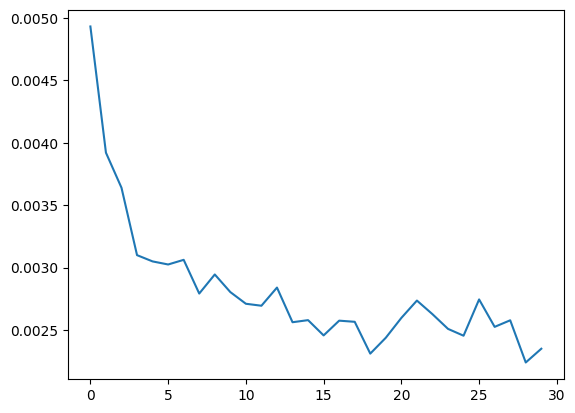

In [16]:
plt.plot(training_loss)

# evaluation

In [16]:
hits = 0
total_pairs = 0

model.eval()
with torch.no_grad():
    for img1, img2, label in tqdm(loader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)

        output = model(img1, img2)
        output = output.sigmoid().ge(0.5).long()
        hits += torch.sum(output == label).item()
        
        total_pairs += img1.size(0)
        

100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


In [17]:
print("similarity acc", ":", hits/total_pairs )

similarity acc : 0.8058035714285714


In [18]:
confusion_matrix = IncrementalConfusionMatrix(len(dataset.char_paths))

model.eval()
with torch.no_grad():
    for query_set, support_set, label in tqdm(few_shot_loader):
        query_set = query_set.to(device)
        support_set = support_set.to(device)
        
        b, num_class, shot_size, c, h, w = support_set.shape
        support_set = support_set.reshape(-1, c, h, w)
        
        query_feature = model.feature_extract(query_set)
        support_feature = model.feature_extract(support_set)
        
        dif = torch.abs(query_feature.repeat(num_class * shot_size, 1) - support_feature)
        output = model.clf(dif)
        output = output.reshape(b, num_class, shot_size)
        output = output.sum(-1).argmax(-1)
        
        confusion_matrix.update(label, output.detach().cpu())

100%|██████████| 31/31 [00:34<00:00,  1.11s/it]


In [21]:
evaluator = ClassificationEvaluator(label_size, device)

In [25]:
per_class_accuracy = evaluator.get_per_class_accuracy(confusion_matrix)

evaluator.show_per_class_accuracy([path.stem for path in dataset.char_paths], per_class_accuracy.round(2))

character01: 0.0
character02: 0.0
character03: 0.03
character04: 0.05
character05: 0.04
character06: 0.0
character07: 0.0
character08: 0.05
character09: 0.04
character10: 0.0
character11: 0.03
character12: 0.0
character13: 0.0
character14: 0.0
character15: 0.0
character16: 0.03
character17: 0.03
character18: 0.06
character19: 0.03
character20: 0.05
character21: 0.0
character22: 0.04
character23: 0.0
character24: 0.0
character25: 0.22
character26: 0.07
character27: 0.05
character28: 0.0
character29: 0.08
character30: 0.0
character31: 0.0
character32: 0.03
character33: 0.12
character34: 0.0
character35: 0.1
character36: 0.0
character37: 0.0
character38: 0.0
character39: 0.06
character40: 0.03
character41: 0.12


In [14]:
model_path = artifact_path / "siamese.pth"

In [21]:
torch.save(model.state_dict(), model_path)

In [15]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Visualization

In [1]:
from umap import UMAP

d:\research\pytorch-implementations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
model.eval()
with torch.no_grad():
    embed = []
    color = []
    for query_set, support_set, label in tqdm(few_shot_loader):
        query_set = query_set.to(device)
        output = model.feature_extract(query_set)
        embed.append(output)
        color.append(label)

embed = torch.cat(embed)
color = torch.cat(color)

100%|██████████| 31/31 [00:26<00:00,  1.15it/s]


In [27]:
embed_model = UMAP()
embedding = embed_model.fit_transform(embed.detach().cpu().numpy())

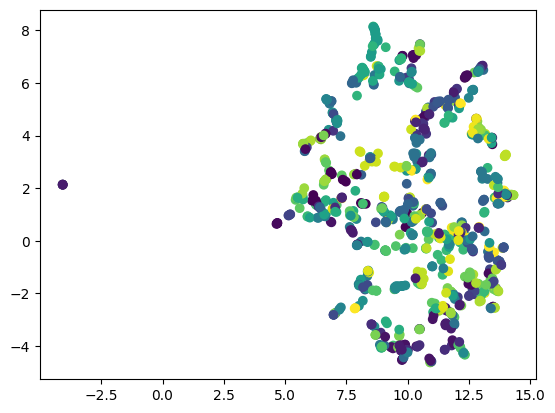

In [28]:
plt.scatter(embedding[:,0],embedding[:,1], c=color)